In [1]:
# ======== importing modules ========
from pytransit import MandelAgol
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.nan)
import pandas as pd

fs = 22; ms = 4 #fontsize, markersize

#========== Karen's inverse weighted binning function =======
def Bin_func(time,flux,error,binsize):
    import warnings
    warnings.filterwarnings("ignore")
    good = np.where(np.isfinite(time)) # finding where values are finite and "Not a Number (NaN)" or +/- infinite (inf)
    timefit = time[good] 
    fluxfit = flux[good] #using indices where values are finite, find where times, flux and errors are also finite
    errfit  = error[good]
    timemax = np.max(timefit) #find max time (or last time measurement)
    timemin = np.min(timefit) #find min time (or first time measurement)
    npoints = len(timefit)    #find number of data points
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days to nearest interger
    bintime = np.full((nbins,), np.nan) 
    binflux = np.full((nbins,), np.nan) #creating an empty array full of NaNs to fill in below
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )] #with given binsize, searching over smaller areas (aka windows) (t-window) to (t+window)
        if tobin[0] != -1:
    #     inverse variance weighted means; read about here: https://en.wikipedia.org/wiki/Inverse-variance_weighting
    
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime)) #checking again for NaNs and infs that might be created by previous step
    bintime = bintime[good2]
    binflux = binflux[good2] 
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr #here you have binned data with averaged values based on the bin sizes you've selected


def GLS(time,flux,fluxerror):
    from PyAstronomy.pyTiming import pyPeriod
    # Compute the GLS periodogram with default options.
    # Choose Zechmeister-Kuerster normalization explicitly
    
#     clp = pyPeriod.Gls((time, flux, fluxerror), norm="ZK", verbose=True)
    clp = pyPeriod.Gls((time, flux, fluxerror), norm="chisq", verbose=True)    

    # Get index associated with highest power
    ifmax = np.argmax(clp.power)
    # and highest power and associated frequency
    pmax = clp.power[ifmax]
    fmax = clp.freq[ifmax]
    # Convert frequency into period
    hpp = 1./fmax
#     print("Highest-power period: ", hpp)

    # Calculate sine wave associated with 'best-fit' frequency
    bestSine = clp.sinmod(time)
    
    return bestSine, 1./fmax

In [11]:
#------------------------------Finding Downloaded TESS Data Files --------------------------------------
path = '/Users/felizd/Desktop/Felix/TESSdata/' #location of where I put downloaded files

data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print "number of files: ",len(data) #number of files

for d in range(len(data)):
    print "data set #", d+1 ," : ", data[d] #I added the d+1 because python does zero-indexing (https://en.wikipedia.org/wiki/Zero-based_numbering)
    print ""

number of files:  11
data set # 1  :  /Users/felizd/Desktop/Felix/TESSdata/147284933_sector01_1_1.lc

data set # 2  :  /Users/felizd/Desktop/Felix/TESSdata/197766151_sector01_2_4.lc

data set # 3  :  /Users/felizd/Desktop/Felix/TESSdata/197766674_sector01_2_4.lc

data set # 4  :  /Users/felizd/Desktop/Felix/TESSdata/219338655_sector01_2_2.lc

data set # 5  :  /Users/felizd/Desktop/Felix/TESSdata/289936047_sector01_1_4.lc

data set # 6  :  /Users/felizd/Desktop/Felix/TESSdata/308603891_sector01_4_3.lc

data set # 7  :  /Users/felizd/Desktop/Felix/TESSdata/308613181_sector01_4_3.lc

data set # 8  :  /Users/felizd/Desktop/Felix/TESSdata/308613184_sector01_4_3.lc

data set # 9  :  /Users/felizd/Desktop/Felix/TESSdata/339578053_sector01_2_2.lc

data set # 10  :  /Users/felizd/Desktop/Felix/TESSdata/426018816_sector01_3_3.lc

data set # 11  :  /Users/felizd/Desktop/Felix/TESSdata/441409656_sector01_1_4.lc



In [3]:
def bin_and_clip(data,binsize,Nsig): #this definition simply bins the data and cuts out outliers

    d = np.transpose(np.loadtxt(data))
    t = d[0]
    m = d[1]/np.nanmean(d[1]) #normalized
    e = d[2]

    f = 10.0**(m/-2.5)/np.mean(10.0**(m/-2.5)) #converting from mag to flux and normalizing

    bint,binm,binfe = Bin_func(t,m,e, binsize) #binning data
    binf = 10.0**(binm/-2.5)/np.mean(10.0**(binm/-2.5))

    cut = np.where(binf< (np.mean(binf)+np.std(binf)))[0] #cutting ONLY data above 1 std above the mean

    return bint[cut],binf[cut],binfe[cut]

In [4]:
print " So 1 of our two candidates is likely a blend, let's look at a nearby star for our other candidate (TIC 197766674)"

 So 1 of our two candidates is likely a blend, let's look at a nearby star for our other candidate (TIC 197766674)


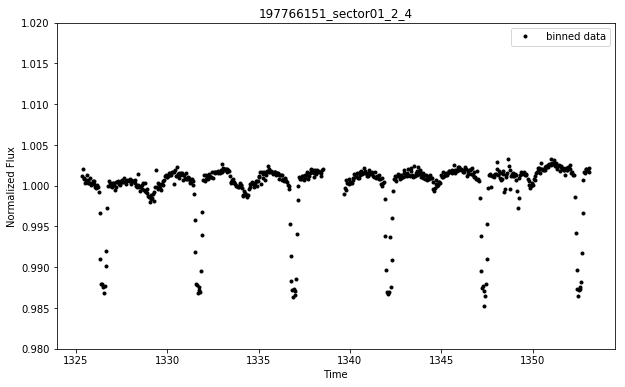

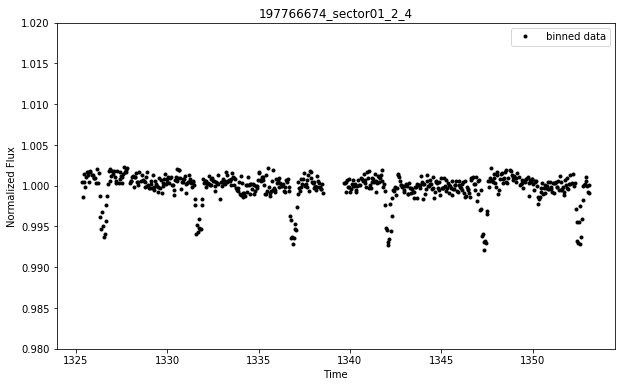

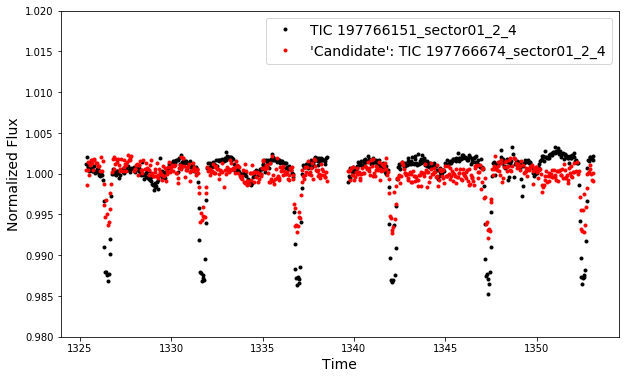

In [20]:
interesting = (data[1],data[2])
binsize = (1./24.0); Nsig=3.0

for x in range(len(interesting)):
    bint,binf,binfe = bin_and_clip(interesting[x],binsize,Nsig)
    
    plt.figure(figsize=(10,6))
    plt.plot(bint,binf,marker='.',color='k',linestyle='none',label=" binned data")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.legend(loc='best') 
    # plt.gca().invert_yaxis()
    plt.ylim(0.98,1.02)
    plt.title(interesting[x][37:-3])
    plt.savefig(str(interesting[x][37:-3])+"_lightcurve.png")
    plt.show()
    

bintA,binfA,binfeA = bin_and_clip(data[1],binsize,Nsig)
bintB,binfB,binfeB = bin_and_clip(data[2],binsize,Nsig)

plt.figure(figsize=(10,6))
plt.plot(bintA,binfA,marker='.',color='k',linestyle='none',label="TIC "+str(data[1][37:-3]))
plt.plot(bintB,binfB,marker='.',color='r',linestyle='none',label="'Candidate': TIC "+str(data[2][37:-3]))
plt.xlabel("Time",fontsize=14) 
plt.ylabel("Normalized Flux",fontsize=14) 
plt.legend(loc='best',fontsize=14)  
# plt.gca().invert_yaxis()
plt.ylim(0.98,1.02)
plt.savefig("Candidate1.png")
plt.show()    

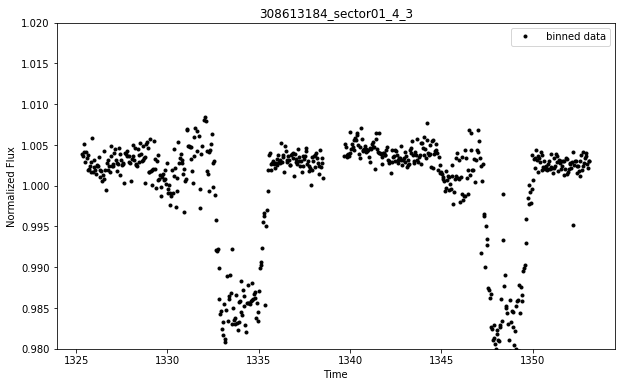

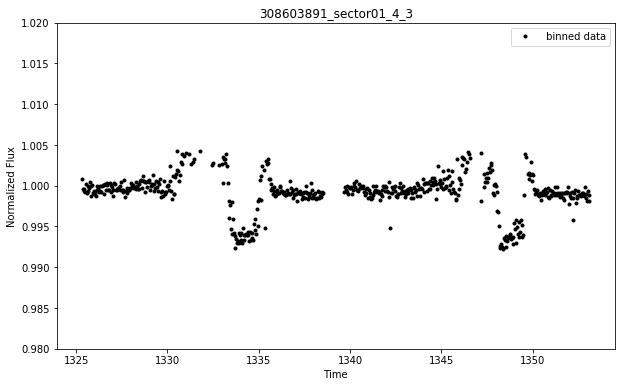

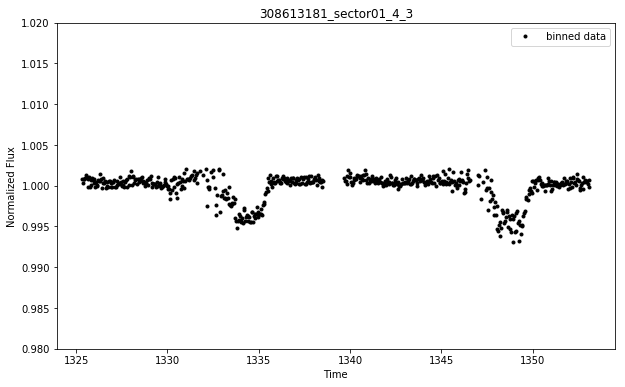

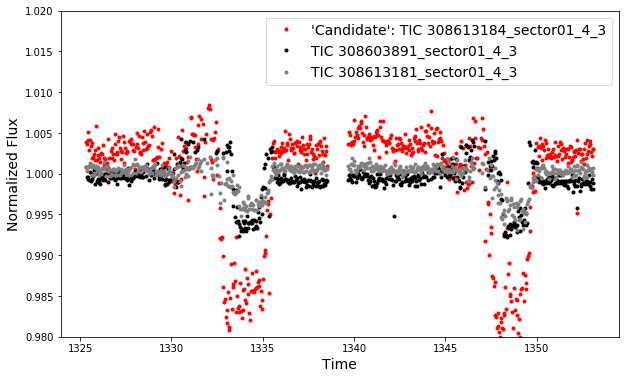

In [19]:
interesting=[data[7],data[5],data[6]]
binsize = (1./24.0); Nsig=3.0

for x in range(len(interesting)):
    bint,binf,binfe = bin_and_clip(interesting[x],binsize,Nsig)
    
    plt.figure(figsize=(10,6))
    plt.plot(bint,binf,marker='.',color='k',linestyle='none',label=" binned data")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.legend(loc='best') 
    # plt.gca().invert_yaxis()
    plt.ylim(0.98,1.02)
    plt.title(interesting[x][37:-3])
    plt.savefig(str(interesting[x][37:-3])+"_lightcurve.png")
    plt.show()
    

bintA,binfA,binfeA = bin_and_clip(data[7],binsize,Nsig)
bintB,binfB,binfeB = bin_and_clip(data[5],binsize,Nsig)
bintC,binfC,binfeC = bin_and_clip(data[6],binsize,Nsig)

plt.figure(figsize=(10,6))
plt.plot(bintA,binfA,marker='.',color='r',linestyle='none',label="'Candidate': TIC "+str(data[7][37:-3]))
plt.plot(bintB,binfB,marker='.',color='k',linestyle='none',label="TIC "+str(data[5][37:-3]))
plt.plot(bintC,binfC,marker='.',color='grey',linestyle='none',label="TIC "+str(data[6][37:-3]))
plt.xlabel("Time",fontsize=14) 
plt.ylabel("Normalized Flux",fontsize=14) 
plt.legend(loc='best',fontsize=14) 
# plt.gca().invert_yaxis()
plt.ylim(0.98,1.02)
plt.savefig("Candidate2.png")
plt.show()    

In [8]:
print "see how these events happen at the exact times? Our candidate's star is likely passing in front of another background star"

see how these events happen at the exact times? Our candidate's star is likely passing in front of another background star
